[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/Gan_Reshape_Concat.ipynb)

In [0]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)
X = tf.placeholder(tf.float32, [None, 28 * 28]) # MNIST = 28*28

Z = tf.placeholder(tf.float32, [None, 64]) # Noise Dimension = 64
Z1 =  tf.placeholder(tf.float32, [None, 64]) # Noise Dimension = 64


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Output Activation 을  Sigmoid 와 leaky_relu로 생성되는 것들 다르게 실험

In [0]:

n_hidden = 256 
n_hidden2 = 128
n_input = 28 * 14

def generator_1(noise_z): # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("generator1"  ) :
        hidden = tf.layers.dense( noise_z , n_hidden  )
        hidden2 = tf.layers.dense( hidden , n_hidden2 )
        #hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.relu)
        output = tf.layers.dense(hidden2 , n_input , activation = tf.nn.leaky_relu )
      
    return output 


def generator_2(noise_z):  # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("generator2"   ) :  
        hidden = tf.layers.dense( noise_z , n_hidden  ) # , activation = tf.nn.sigmoid 
        hidden2 = tf.layers.dense( hidden , n_hidden2 ) # , activation = tf.nn.relu 
        #hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.relu) 
        output = tf.layers.dense(hidden2 , n_input , activation = tf.nn.sigmoid )
        
    return output



def discriminator(inputs , reuse = None ): # 64 -> 256 -> 128 -> 256 ->  28*14
    with tf.variable_scope("discriminator" ) as scope :
        if reuse :
            scope.reuse_variables()
            
        hidden = tf.layers.dense( inputs , n_hidden  ) # , activation= tf.nn.relu
        hidden2 = tf.layers.dense( hidden , n_hidden2 )
        hidden3 = tf.layers.dense( hidden2 , n_hidden , activation = tf.nn.leaky_relu)
        output = tf.layers.dense( hidden3 , 1 , activation = tf.nn.sigmoid)
        output2 = tf.layers.dense( hidden3 , 1 , activation = None )
    return output , output2



In [0]:
G1 = generator_1(Z) 
G2 = generator_2(Z1) 

In [5]:
import tensorflow as tf
import numpy as np

ph = tf.placeholder(shape=[None,4], dtype=tf.int32)

# look the -1 in the first position
x = tf.slice(ph, [0, 0], [-1 ,  2])

input_ = np.array([[1,2,3,4],
                   [3,4,5,6],
                   [5,6,7,8],
                   [1,2,3,4]])




with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        print(sess.run(x, feed_dict={ph: input_}))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[[1 2]
 [3 4]
 [5 6]
 [1 2]]


### Slice로 학습하니 잘 안됨

```
print(G1)
print(G2)
G3 = tf.slice(G1 , [0,0 ] , [-1, 196 ])
G4 = tf.slice(G1 , [0,196 ] , [-1, 196 ])
G5 = tf.slice(G2 , [0,0 ] , [-1, 196 ])
G6 = tf.slice(G1 , [0,196 ] , [-1, 196 ])

print(G3 ,G4 )
print(G5, G6)

G = tf.concat([ G3, G5 ,G4 ,G6 ], axis =1 )
G
```



# Tf.reshape 를 활용해서 28*14 , 28*14 로 cocnat 후 Reshape 해주니 원하는 대로 이미지가 학습이 되었다!

In [6]:
G3 = tf.reshape(G1 , [-1 , 28, 14 ])
G4 = tf.reshape(G2 , [-1 , 28, 14 ])

G5 =  tf.concat([G3, G4] , axis =2 )


G = tf.reshape(G5, shape=(-1, 784 ))
print(G )

Tensor("Reshape_2:0", shape=(?, 784), dtype=float32)


In [7]:
D_gene , D_logit_fake  = discriminator(G ) 
D_real , D_logit_real = discriminator(X , reuse =  True) 



D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_real, labels = tf.ones_like(D_logit_real)-0.1 ))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,  labels = tf.zeros_like(D_logit_fake)+0.1))
loss_D = D_loss_real + D_loss_fake
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake ,  labels = tf.ones_like(D_logit_fake)-0.1))

vars_D = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="discriminator")
vars_G1 = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="generator1")
vars_G2 = tf.get_collection( tf.GraphKeys.TRAINABLE_VARIABLES , scope="generator2")

vars_G = vars_G1+vars_G2
print(vars_D)
print(vars_G)

train_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=vars_D )
train_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=vars_G )

[<tf.Variable 'discriminator/dense/kernel:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'discriminator/dense/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/kernel:0' shape=(256, 128) dtype=float32_ref>, <tf.Variable 'discriminator/dense_1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_2/kernel:0' shape=(128, 256) dtype=float32_ref>, <tf.Variable 'discriminator/dense_2/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_3/kernel:0' shape=(256, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_3/bias:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'discriminator/dense_4/kernel:0' shape=(256, 1) dtype=float32_ref>, <tf.Variable 'discriminator/dense_4/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'generator1/dense/kernel:0' shape=(64, 256) dtype=float32_ref>, <tf.Variable 'generator1/dense/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator1/dense_1/kernel:0' shape=(256, 128) d

# 문제 발생

Generator NN 2개를 이용해 출력한 것을 Concat을 해서 사용하고 싶은데  ,  LOSS 값이 None 값이 나옵니다. 


##  Solution 
*  _ , d1 = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise  , Z1 : noise2 }) 

# 문제발생2

loss 값이 nan 값이 출력됨

## Solution - log 수식 대신에  sigmoid_cross_entropy_with_logits 사용 
```
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_real, labels = tf.ones_like(D_logit_real)-0.1 ))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake,  labels = tf.zeros_like(D_logit_fake)+0.1))
loss_D = D_loss_real + D_loss_fake
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logit_fake ,  labels = tf.ones_like(D_logit_fake)-0.1))
```

# 문제발생3 

실제로 학습시키고 싶은 것은 Column 별로 학습을 시키고 싶은데,  그냥하게되면  행기준으로 (14*28) / (14*28) 이렇게 생성되는 것 같은데 ,  이것은 Transpose 해서 ( 28*14 / 28*14) 로 학습을 시키고 싶음. 단순히 그림을 Transpose 해보면 아래 그림과 같이 정체불명의 그림이 나에고 됨 

### 그래서 궁금한 점은 그대로 (14 * 28 / 14 * 28 ) 로 학습을 시켜도 결국 나중에는 column 별로 학습되는 효과가 있는건지 궁금 




epoch 0 LOSS D :  0.8469492
epoch 0 LOSS G :  1.651601


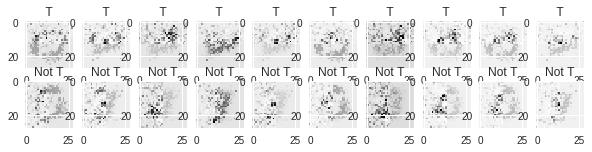

epoch 4 LOSS D :  0.7775002
epoch 4 LOSS G :  1.7978358


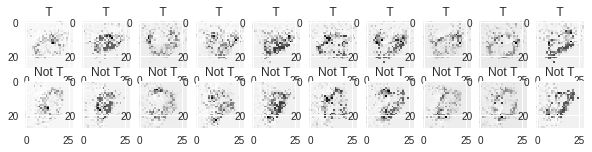

epoch 9 LOSS D :  0.7939532
epoch 9 LOSS G :  1.9005855


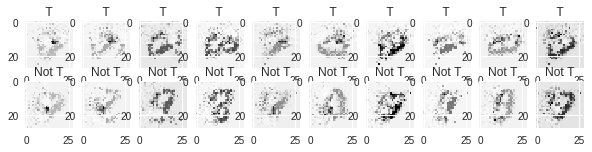

epoch 14 LOSS D :  0.7268771
epoch 14 LOSS G :  1.9464868


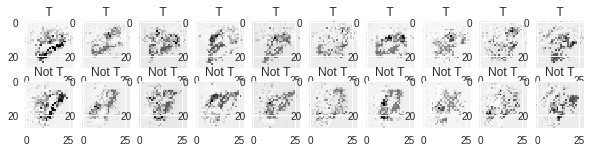

epoch 19 LOSS D :  0.7649751
epoch 19 LOSS G :  1.950568


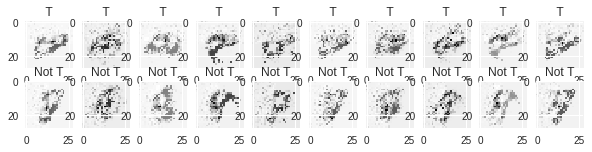

epoch 24 LOSS D :  0.7386851
epoch 24 LOSS G :  1.8047959


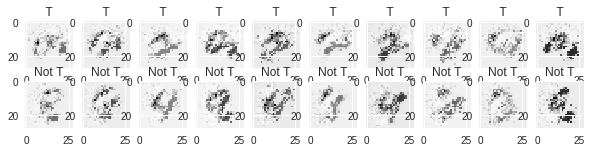

epoch 29 LOSS D :  0.74199975
epoch 29 LOSS G :  1.9497986


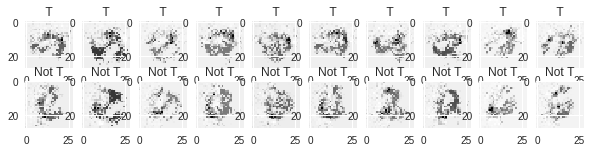

epoch 34 LOSS D :  0.6988627
epoch 34 LOSS G :  1.9634011


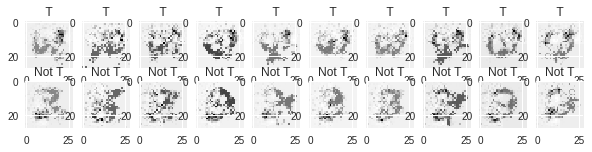

epoch 39 LOSS D :  0.74417347
epoch 39 LOSS G :  2.0613768


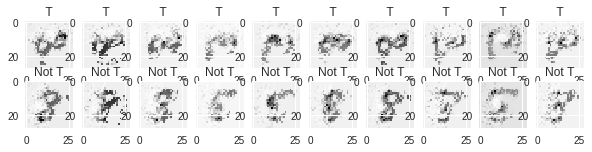

epoch 44 LOSS D :  0.7073046
epoch 44 LOSS G :  1.9755206


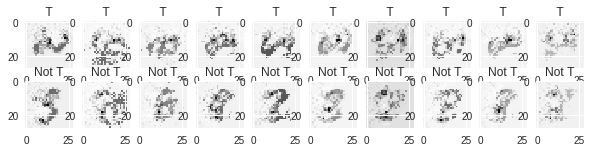

epoch 49 LOSS D :  0.7029296
epoch 49 LOSS G :  2.0206952


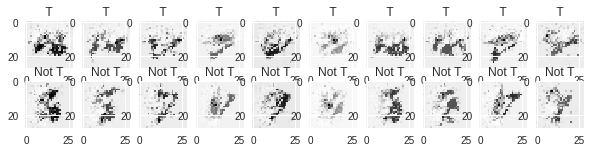

epoch 54 LOSS D :  0.73201084
epoch 54 LOSS G :  2.0401397


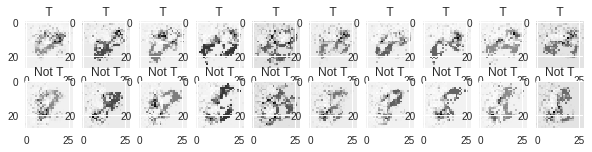

epoch 59 LOSS D :  0.7303258
epoch 59 LOSS G :  2.0930846


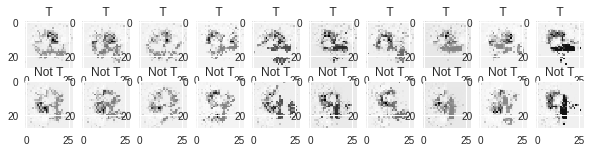

epoch 64 LOSS D :  0.7083559
epoch 64 LOSS G :  1.9401485


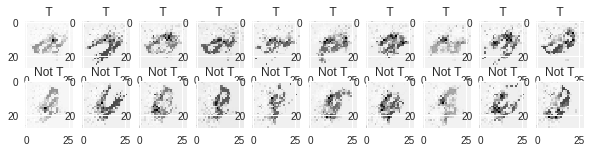

epoch 69 LOSS D :  0.7118155
epoch 69 LOSS G :  1.9734519


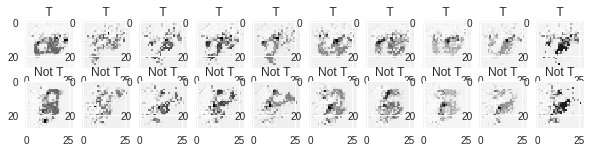

epoch 74 LOSS D :  0.70163447
epoch 74 LOSS G :  2.1330624


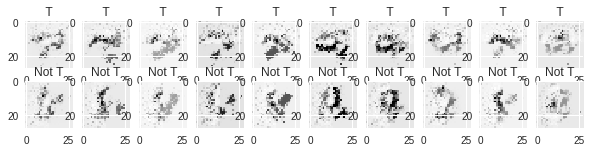

epoch 79 LOSS D :  0.7265678
epoch 79 LOSS G :  2.09258


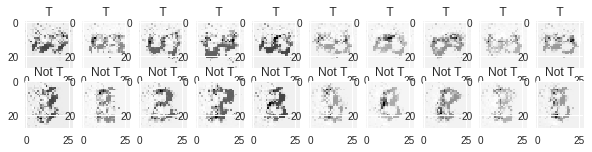

epoch 84 LOSS D :  0.6889535
epoch 84 LOSS G :  2.102252


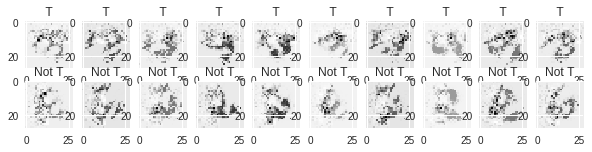

epoch 89 LOSS D :  0.7010137
epoch 89 LOSS G :  2.139875


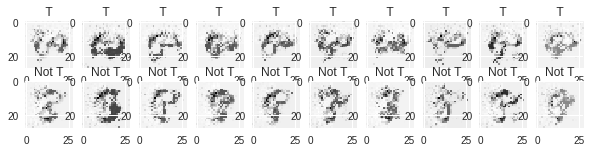

epoch 94 LOSS D :  0.7118788
epoch 94 LOSS G :  1.9098892


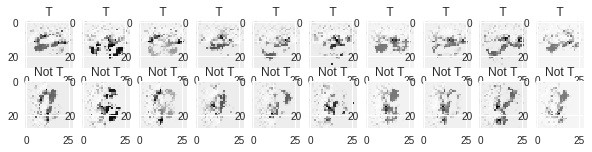

epoch 99 LOSS D :  0.6862462
epoch 99 LOSS G :  2.125806


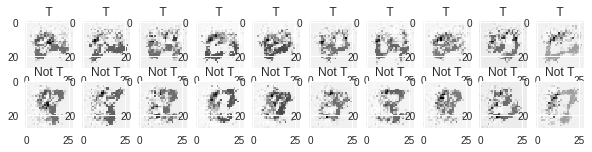

epoch 104 LOSS D :  0.7338377
epoch 104 LOSS G :  2.0319717


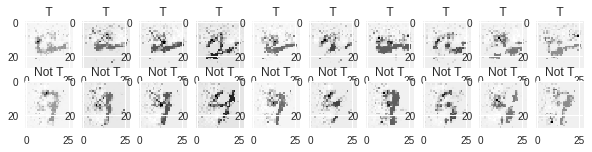

epoch 109 LOSS D :  0.71641576
epoch 109 LOSS G :  1.9667112


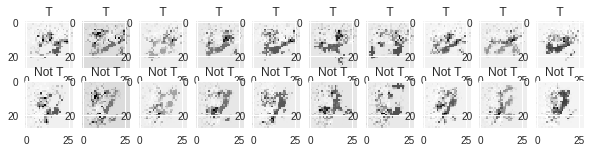

epoch 114 LOSS D :  0.74108124
epoch 114 LOSS G :  2.140745


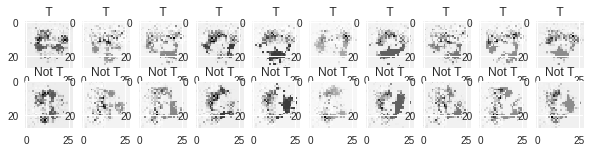

epoch 119 LOSS D :  0.7332516
epoch 119 LOSS G :  2.1013787


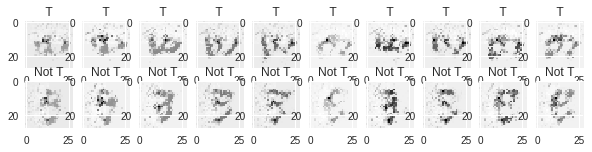

epoch 124 LOSS D :  0.73071074
epoch 124 LOSS G :  1.8773584


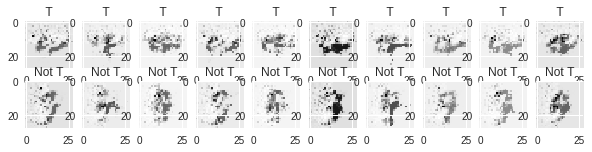

epoch 129 LOSS D :  0.77429426
epoch 129 LOSS G :  1.8393762


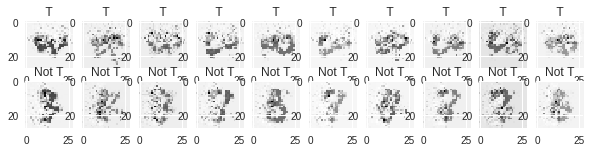

epoch 134 LOSS D :  0.7221933
epoch 134 LOSS G :  2.0532022


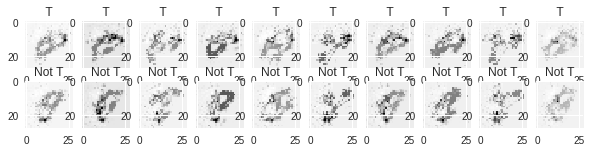

epoch 139 LOSS D :  0.69420564
epoch 139 LOSS G :  1.9316075


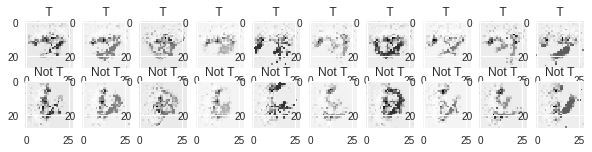

epoch 144 LOSS D :  0.6927347
epoch 144 LOSS G :  2.081775


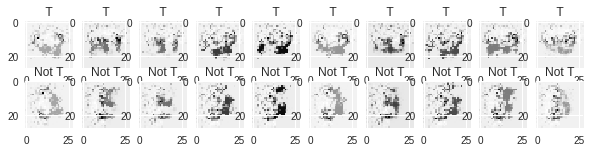

epoch 149 LOSS D :  0.6938799
epoch 149 LOSS G :  1.9391233


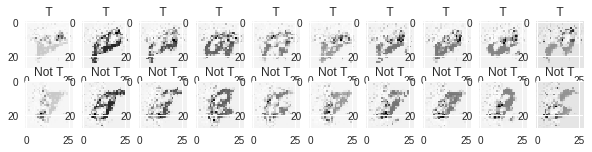

epoch 154 LOSS D :  0.7235651
epoch 154 LOSS G :  2.0181692


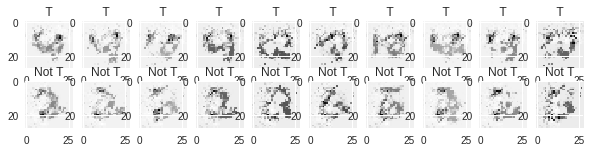

epoch 159 LOSS D :  0.7119242
epoch 159 LOSS G :  2.005314


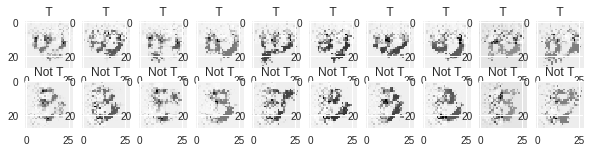

epoch 164 LOSS D :  0.72384274
epoch 164 LOSS G :  2.1415255


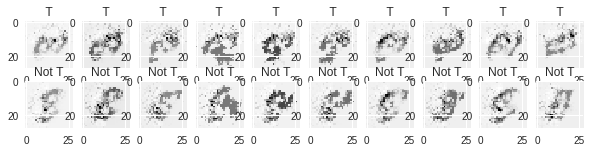

epoch 169 LOSS D :  0.7204597
epoch 169 LOSS G :  1.8579701


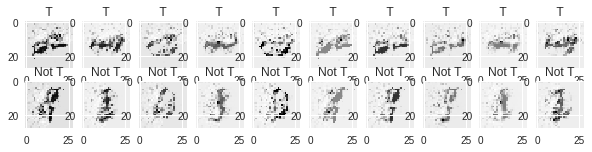

epoch 174 LOSS D :  0.7062242
epoch 174 LOSS G :  1.983467


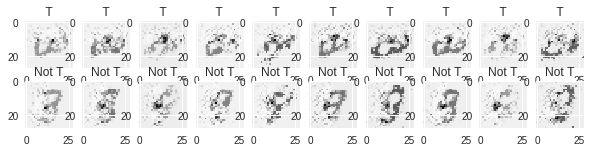

epoch 179 LOSS D :  0.7098415
epoch 179 LOSS G :  2.0151358


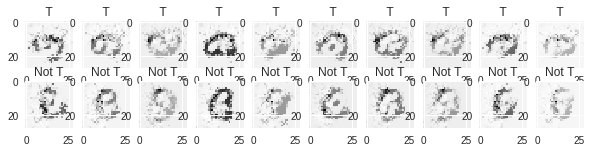

epoch 184 LOSS D :  0.7104726
epoch 184 LOSS G :  1.9667648


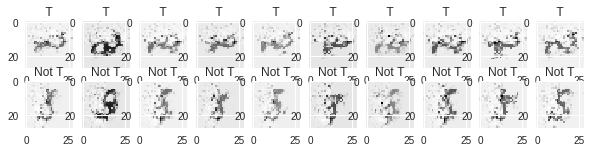

epoch 189 LOSS D :  0.70383835
epoch 189 LOSS G :  2.0341375


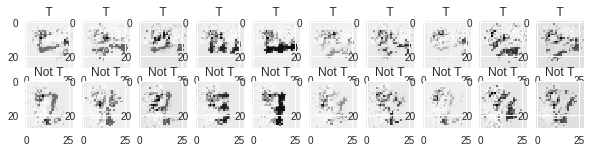

epoch 194 LOSS D :  0.71900713
epoch 194 LOSS G :  1.9809003


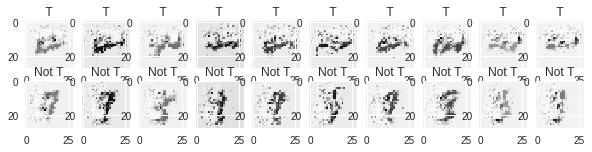

epoch 199 LOSS D :  0.69074774
epoch 199 LOSS G :  2.00727


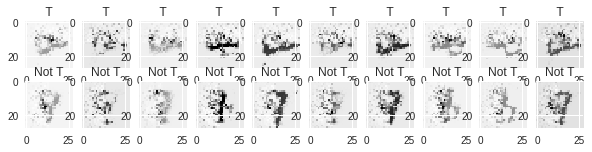

epoch 204 LOSS D :  0.72286665
epoch 204 LOSS G :  2.065129


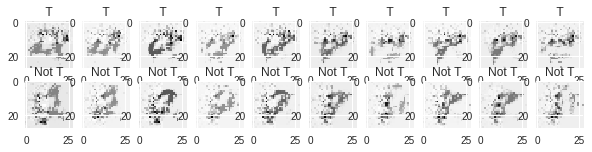

epoch 209 LOSS D :  0.73683715
epoch 209 LOSS G :  2.0660725


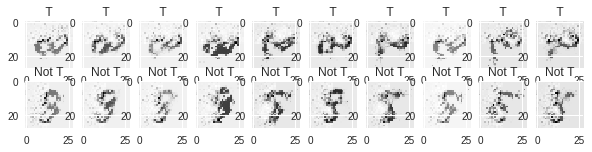

epoch 214 LOSS D :  0.7050755
epoch 214 LOSS G :  1.9332329


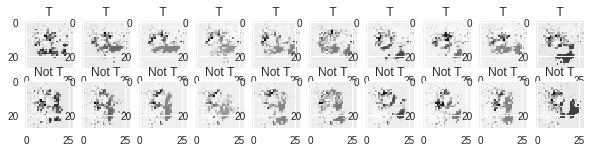

epoch 219 LOSS D :  0.70395994
epoch 219 LOSS G :  2.0778794


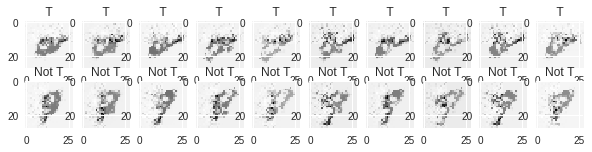

epoch 224 LOSS D :  0.69975555
epoch 224 LOSS G :  2.0604403


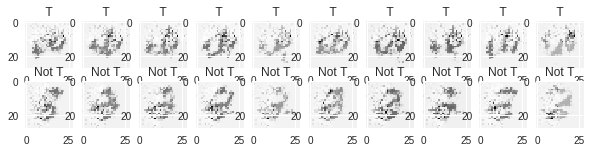

epoch 229 LOSS D :  0.6926447
epoch 229 LOSS G :  2.0685534


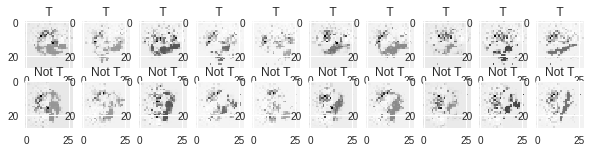

epoch 234 LOSS D :  0.7040503
epoch 234 LOSS G :  2.0059888


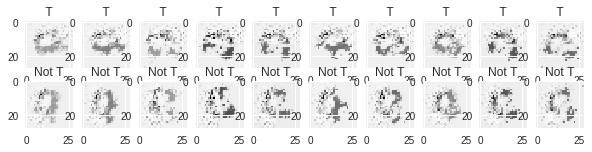

epoch 239 LOSS D :  0.70145965
epoch 239 LOSS G :  2.022186


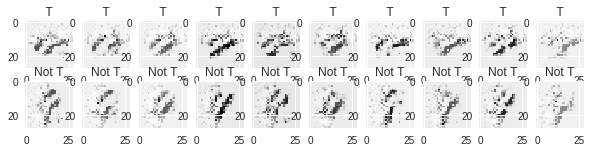

epoch 244 LOSS D :  0.7035303
epoch 244 LOSS G :  1.9323473


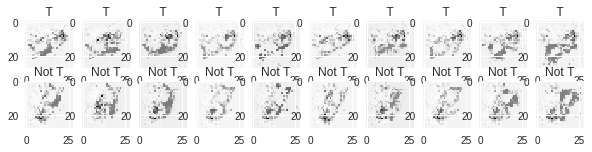

epoch 249 LOSS D :  0.72265446
epoch 249 LOSS G :  2.0182676


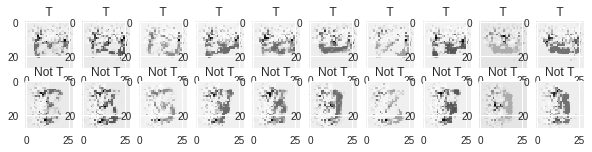

epoch 254 LOSS D :  0.72815686
epoch 254 LOSS G :  1.9782104


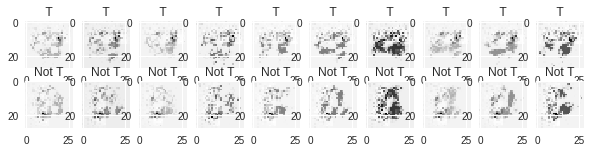

epoch 259 LOSS D :  0.7066626
epoch 259 LOSS G :  2.0140076


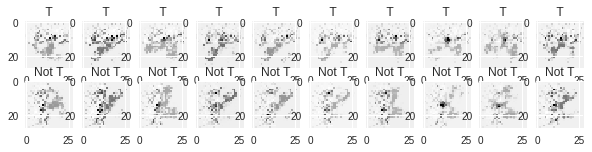

epoch 264 LOSS D :  0.75067544
epoch 264 LOSS G :  1.9531028


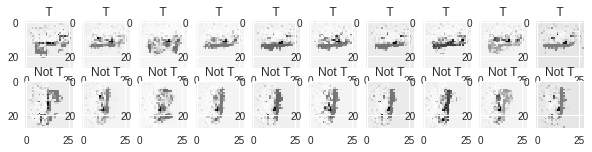

epoch 269 LOSS D :  0.7033721
epoch 269 LOSS G :  1.9854736


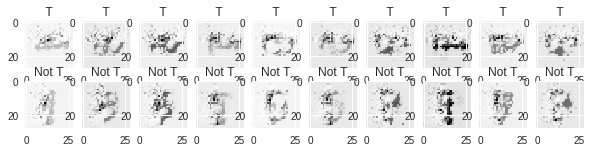

epoch 274 LOSS D :  0.73556995
epoch 274 LOSS G :  2.134046


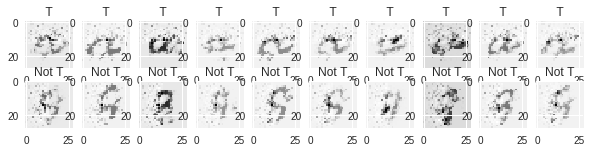

epoch 279 LOSS D :  0.7160422
epoch 279 LOSS G :  1.9315952


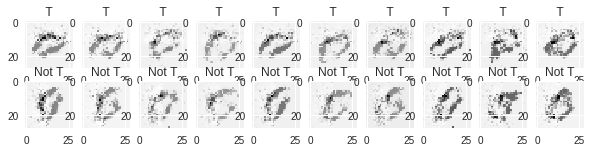

epoch 284 LOSS D :  0.73098135
epoch 284 LOSS G :  2.0384357


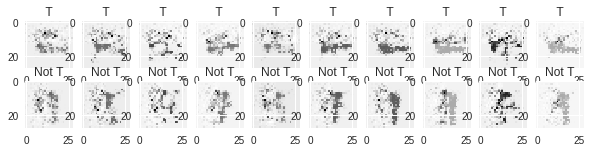

epoch 289 LOSS D :  0.70836467
epoch 289 LOSS G :  1.9481115


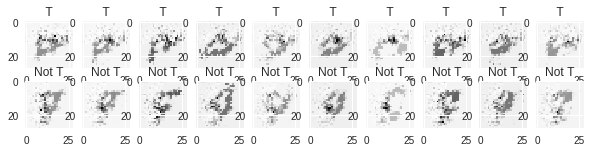

epoch 294 LOSS D :  0.72124195
epoch 294 LOSS G :  1.9609461


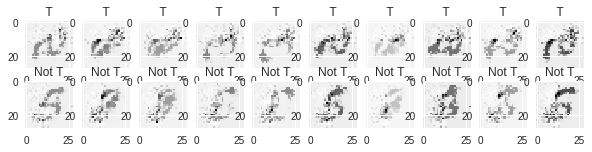

epoch 299 LOSS D :  0.703369
epoch 299 LOSS G :  1.9666853


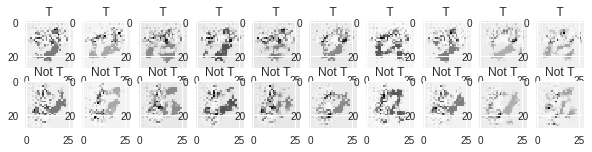

epoch 304 LOSS D :  0.71623015
epoch 304 LOSS G :  1.938248


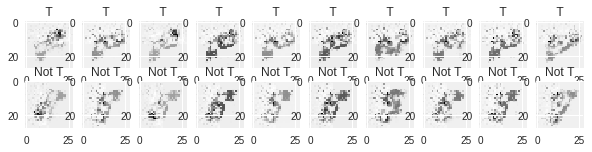

epoch 309 LOSS D :  0.72909737
epoch 309 LOSS G :  1.913882


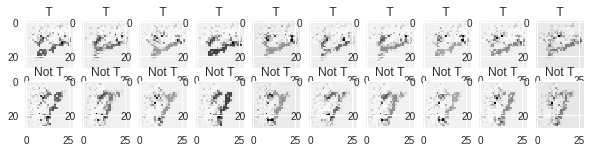

epoch 314 LOSS D :  0.71765006
epoch 314 LOSS G :  1.9185295


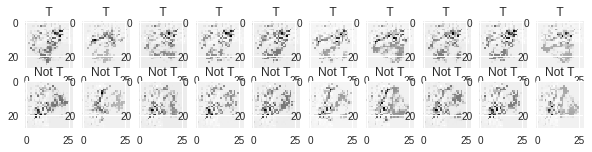

epoch 319 LOSS D :  0.71532345
epoch 319 LOSS G :  2.0590246


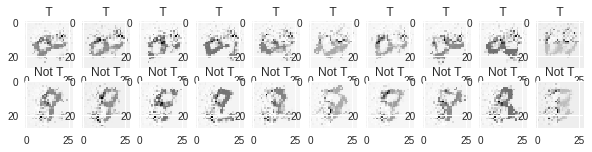

epoch 324 LOSS D :  0.716217
epoch 324 LOSS G :  2.0194867


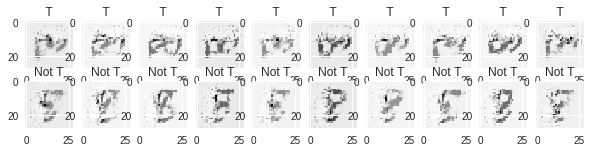

epoch 329 LOSS D :  0.7020526
epoch 329 LOSS G :  2.1685345


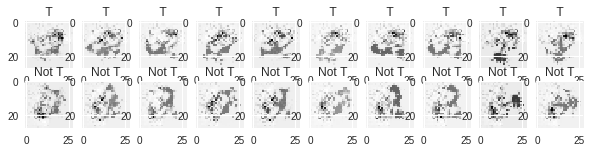

epoch 334 LOSS D :  0.6956926
epoch 334 LOSS G :  1.9568


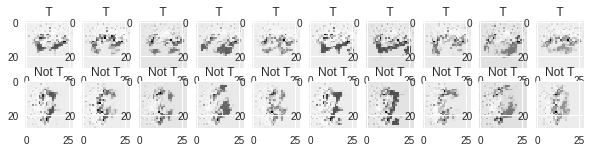

epoch 339 LOSS D :  0.7381103
epoch 339 LOSS G :  2.0410404


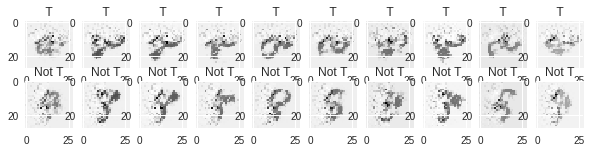

epoch 344 LOSS D :  0.72638637
epoch 344 LOSS G :  1.9855114


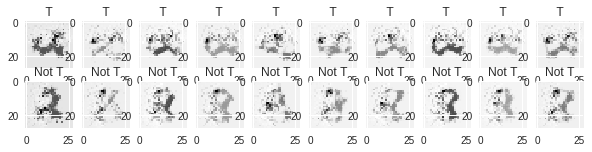

epoch 349 LOSS D :  0.72640675
epoch 349 LOSS G :  1.9067272


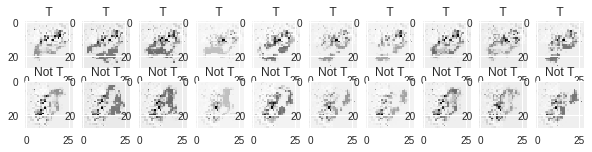

epoch 354 LOSS D :  0.7181523
epoch 354 LOSS G :  2.0185862


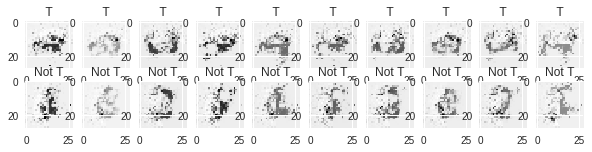

epoch 359 LOSS D :  0.7008165
epoch 359 LOSS G :  1.9602656


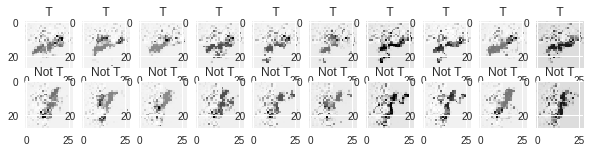

epoch 364 LOSS D :  0.7209746
epoch 364 LOSS G :  1.9022489


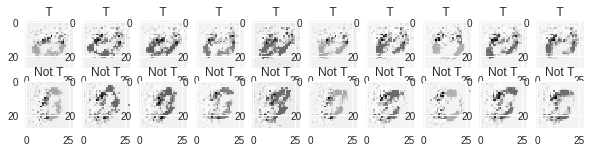

epoch 369 LOSS D :  0.69619226
epoch 369 LOSS G :  2.005396


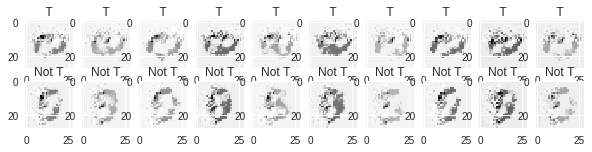

epoch 374 LOSS D :  0.70042795
epoch 374 LOSS G :  2.0037432


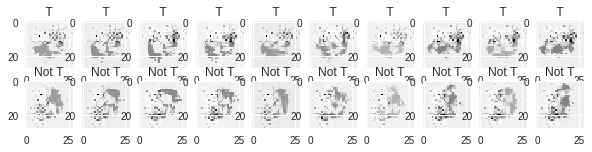

epoch 379 LOSS D :  0.7312966
epoch 379 LOSS G :  1.9185631


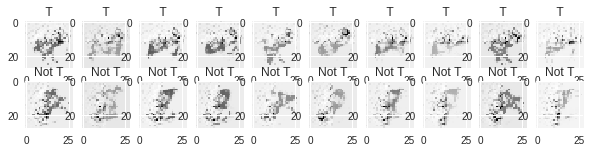

epoch 384 LOSS D :  0.72508025
epoch 384 LOSS G :  2.117711


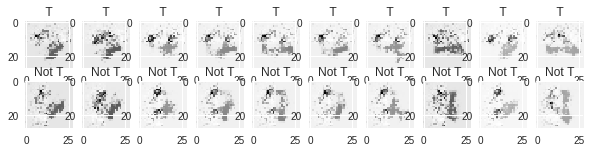

epoch 389 LOSS D :  0.7088227
epoch 389 LOSS G :  2.0361707


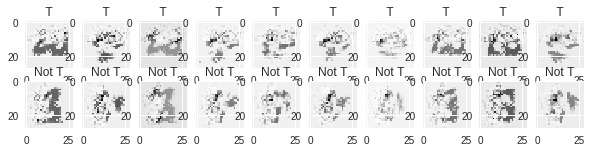

epoch 394 LOSS D :  0.72605515
epoch 394 LOSS G :  1.9830277


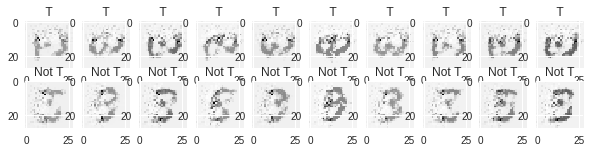

epoch 399 LOSS D :  0.70019484
epoch 399 LOSS G :  2.0003853


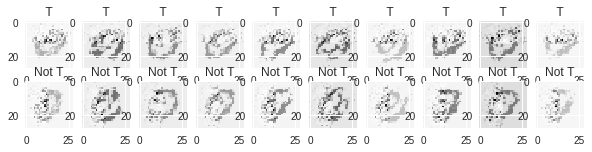

epoch 404 LOSS D :  0.7084987
epoch 404 LOSS G :  2.005966


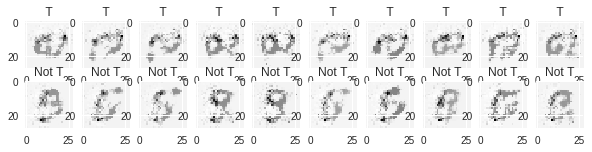

epoch 409 LOSS D :  0.7416754
epoch 409 LOSS G :  1.8423136


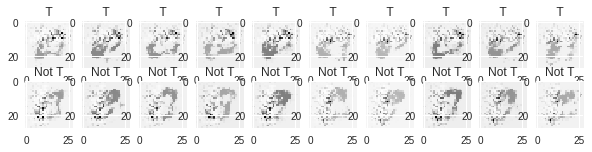

epoch 414 LOSS D :  0.7181479
epoch 414 LOSS G :  1.8947387


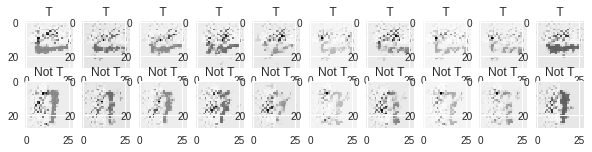

epoch 419 LOSS D :  0.69929206
epoch 419 LOSS G :  2.0130105


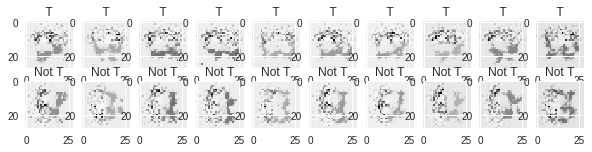

epoch 424 LOSS D :  0.721966
epoch 424 LOSS G :  1.9144654


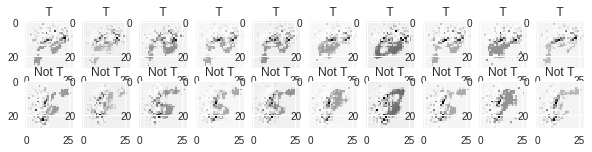

epoch 429 LOSS D :  0.7435138
epoch 429 LOSS G :  2.0390878


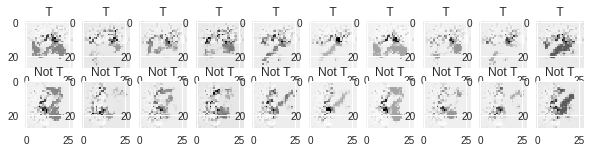

epoch 434 LOSS D :  0.74637413
epoch 434 LOSS G :  1.9078532


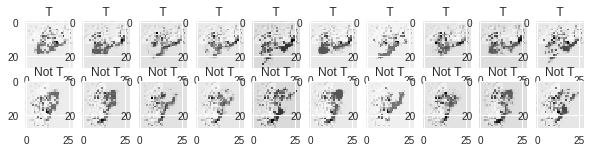

epoch 439 LOSS D :  0.7243216
epoch 439 LOSS G :  2.1420732


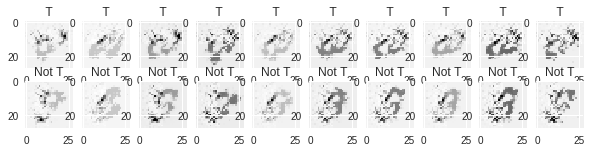

epoch 444 LOSS D :  0.7376977
epoch 444 LOSS G :  1.8860196


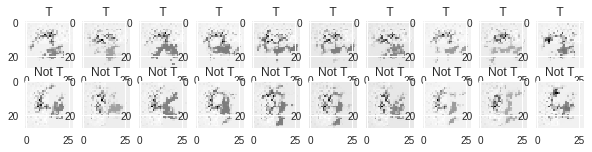

epoch 449 LOSS D :  0.7516403
epoch 449 LOSS G :  1.9297104


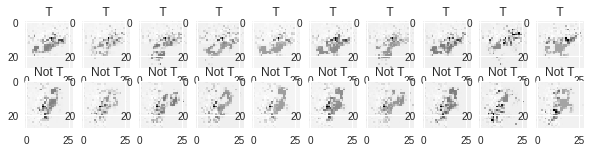

epoch 454 LOSS D :  0.7277758
epoch 454 LOSS G :  1.8620318


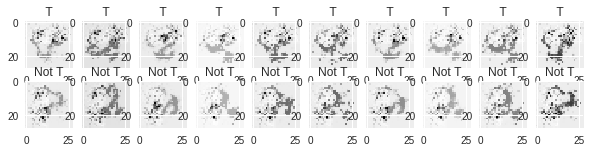

epoch 459 LOSS D :  0.7078444
epoch 459 LOSS G :  1.9276242


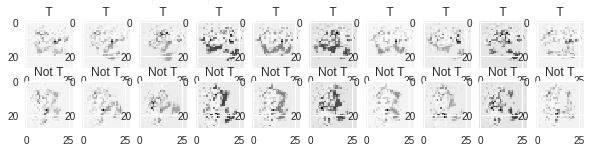

epoch 464 LOSS D :  0.71869993
epoch 464 LOSS G :  2.0234714


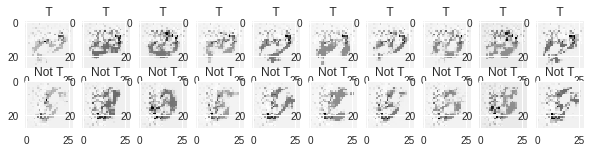

epoch 469 LOSS D :  0.70577145
epoch 469 LOSS G :  2.1126494


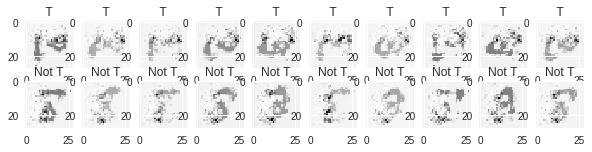

epoch 474 LOSS D :  0.7472575
epoch 474 LOSS G :  1.9611391


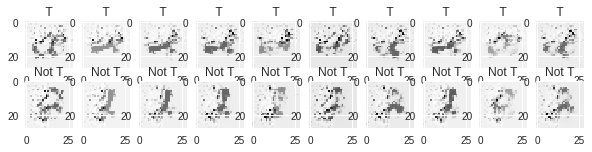

epoch 479 LOSS D :  0.74206185
epoch 479 LOSS G :  1.7979236


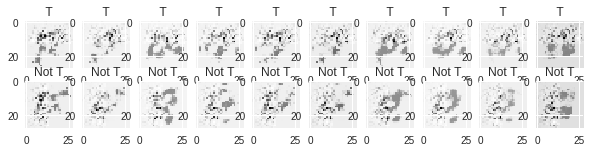

epoch 484 LOSS D :  0.7310154
epoch 484 LOSS G :  1.8991044


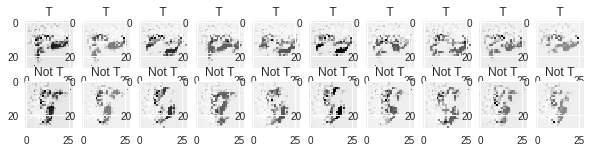

epoch 489 LOSS D :  0.7329086
epoch 489 LOSS G :  1.9978391


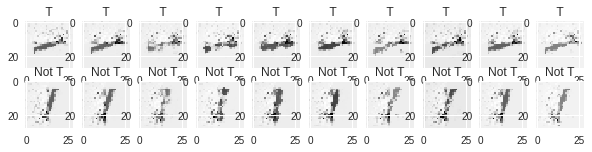

epoch 494 LOSS D :  0.7221962
epoch 494 LOSS G :  1.9393687


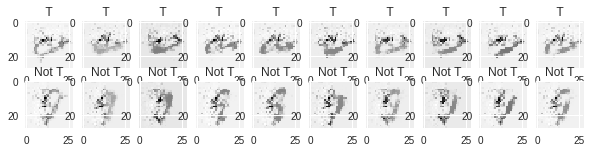

epoch 499 LOSS D :  0.7621211
epoch 499 LOSS G :  1.9041193


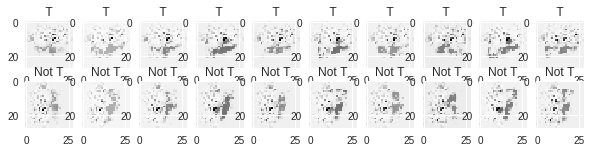

In [8]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session( config = config )
sess.run(tf.global_variables_initializer())

noise_test = np.random.normal(size=(10, 64)) 
noise_test2 = np.random.normal(size=(10, 64)) 

for epoch in range(500): 
    
    for i in range(int(mnist.train.num_examples / 100)): 
      
        batch_xs, _ = mnist.train.next_batch(100)
        noise = np.random.normal(size=(100, 64))
        noise2 = np.random.normal(size=(100, 64))
        
        ## Model Collapse 방지를 위해 generator를 discriminator보다 더  많이 학습 시켜봄 
        for _ in range(1) : 
            _ , d1 = sess.run([train_D, loss_D], feed_dict={X: batch_xs, Z: noise  , Z1 : noise2 })
        for _ in range(2) :
            _ , g1 = sess.run([train_G, loss_G], feed_dict={Z: noise, Z1 : noise2 })
       
        

    if epoch == 0 or (epoch + 1) % 5 == 0: # 5 = Saving Period
        print("epoch", epoch , "LOSS D : " , d1)
        print("epoch", epoch , "LOSS G : " , g1)
        samples = sess.run(G, feed_dict={Z: noise_test , Z1 : noise_test2 })
        

        fig, ax = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            #ax[0, i].set_axis_off()
            #ax[1, i+10].set_axis_off()
            ax[0,i].imshow( np.transpose( np.reshape(samples[i], (28, 28)) ) )
            ax[0,i].set_title(" T ")
            ax[1,i].imshow( np.reshape(samples[i], (28, 28)) ) 
            ax[1,i].set_title("Not T")
        plt.savefig('{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.show()
        plt.close(fig)